In [5]:
import cv2
import numpy as np
import os
import scipy.io as sio
from extractors import Extractors
from random import randint
from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
import random

DATASET_FOLDER = "MSRC_ObjCategImageDatabase_v2"
DESCRIPTOR_FOLDER = "descriptors"

In [11]:
# Extract Image Descriptors from the Dataset
def extract_descriptors(dataset_path, extract_method=Extractors.extract_rgb):
    descriptor_paths = {
        Extractors.extract_rgb: os.path.join(DESCRIPTOR_FOLDER, 'globalRGBhisto'),
        Extractors.extract_random: os.path.join(DESCRIPTOR_FOLDER, 'random')
    }

    if extract_method not in descriptor_paths:
        raise ValueError(f"Invalid extract_method: {extract_method}")

    descriptor_path = descriptor_paths[extract_method]
    if not os.path.exists(descriptor_path):
        os.makedirs(descriptor_path, exist_ok=True)
    for filename in os.listdir(os.path.join(dataset_path, 'Images')):
        if filename.endswith(".bmp"):
            img_path = os.path.join(dataset_path, 'Images', filename)
            img = cv2.imread(img_path).astype(np.float64) / 255.0  # Normalize the image
            fout = os.path.join(descriptor_path, filename).replace('.bmp', '.npy')
            F = extract_method(img)        
            np.save(fout, F)

def get_image_descriptor_mapping(descriptor_type='globalRGBhisto') -> Dict[str, np.ndarray]:
    descriptor_path = os.path.join(DESCRIPTOR_FOLDER, descriptor_type)
    img_to_descriptor = {}
    for filename in os.listdir(descriptor_path):
        if filename.endswith('.npy'):
            img_path = os.path.join(DATASET_FOLDER, 'Images', filename.replace('.npy', '.bmp'))
            descriptor_data = np.load(os.path.join(descriptor_path, filename))
            img_to_descriptor[img_path] = descriptor_data
    return img_to_descriptor

In [12]:
def cvpr_compare(F1, F2):
    # This function should compare F1 to F2 - i.e. compute the distance
    # between the two descriptors
    # For now it just returns a random number
    # dst = np.random.rand()
    dst = np.linalg.norm(F1-F2)
    return dst

def compute_distance(query_img: str, img_desc_dict: Dict[str, np.ndarray], metric="l1") -> List[Tuple[float, str]]:
    # Compute the distance between the query and all other descriptors
    dst = []
    query_img_desc = img_desc_dict[query_img]
    
    for img_path, candidate_desc in img_desc_dict.items():
        if img_path != query_img:  # Skip the query image itself
            distance = cvpr_compare(query_img_desc, candidate_desc)
            dst.append((distance, img_path))
    
    dst.sort(key=lambda x: x[0])
    return dst

def retrieve_similar_images(query_img: str, img_desc_dict: Dict[str, np.ndarray], number: int = 10) -> list:
    # Compute distances
    distances = compute_distance(query_img, img_desc_dict)
    
    # Get the top 'number' similar images
    top_similar_images = distances[:number]
    
    # Display the query image and top similar images
    display_images(query_img, top_similar_images, number)
    
    # Return the list of top similar images
    return [img_path for _, img_path in top_similar_images]

def display_images(query_img: str, top_similar_images: list, number: int):
    fig, axes = plt.subplots(1, number + 1, figsize=(20, 5))
    distances = []
    # Display the query image
    query_img_data = cv2.imread(query_img)
    query_img_data = cv2.cvtColor(query_img_data, cv2.COLOR_BGR2RGB)
    axes[0].imshow(query_img_data)
    axes[0].set_title('Query Image')
    axes[0].axis('off')
    
    # Display the top similar images
    for ax, (distance, img_path) in zip(axes[1:], top_similar_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        distances.append(distance)
    plt.show()
    print("Distances: \n", distances)

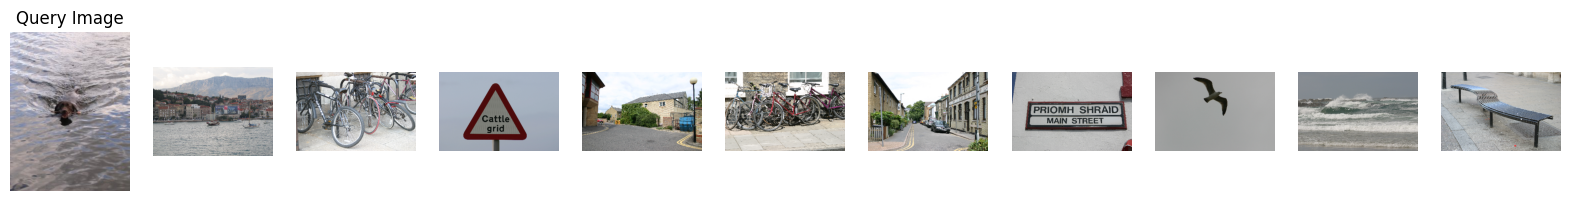

Distances: 
 [np.float64(0.020851446801352782), np.float64(0.0262351613922273), np.float64(0.03181301028847644), np.float64(0.0333365840577471), np.float64(0.03948838193220856), np.float64(0.04111977472723833), np.float64(0.04184110792219873), np.float64(0.04639635607695298), np.float64(0.04641091348893911), np.float64(0.04666489762524918)]


In [13]:
extract_descriptors(DATASET_FOLDER)
img2descriptors = get_image_descriptor_mapping()
random_image = random.choice(list(img2descriptors.keys()))
distances = compute_distance(random_image, img2descriptors)
similar_images = retrieve_similar_images(random_image, img2descriptors)